# ECM-MPT Data Analysis

 The following notebook will go through prediction analysis for the Extracellular-Matrix Multiple Particle Tracking (ECM-MPT) study of pup age in P14, P21, P28, and P35 datasets.


## Table of Contents


  [1.   Load Data](#1.---Load-Data)<br />
  [2.   Analysis](#2.---Analysis)<br />
  [3.   Modelling](#3.---Modelling)<br />
  [4.   Evaluate Results](4.---Evaluate-Results)<br />

---

## 1.   Load Data

Loading feature dataset from AWS NanceLab Bucket: p14, p21, p28, data are present on mckenna.data/08_06_19_MPT_age_dependence while p35 data is present on mckenna.data/07_16_19_MPT_ECM_breakdown. This bucket is only available through access with Nance lab.

There are 15 total videos from each age group. Names of each dataset downloaded are present on dwnld_list.txt.

In [30]:
# libraries used
import boto3
import diff_classifier.aws as aws
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as pl
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

import xgboost as xgb
from xgboost import cv

import shap

In [12]:
dwnld_list = []
source_bucket = 'dash2927.data'
source_folder = 'ECM_work'
keyword = ['P21_40nm', 'P28_40nm', 'NT_brain_2']
s3 = boto3.resource('s3')
bucket = s3.Bucket(source_bucket)

for object in bucket.objects.all():
    folder, filename = ('/'.join(object.key.split("/")
                                 [:-1]), object.key.split("/")[-1])
    # only look in remote_folder and if any keyword(s) math filename
    if folder in source_folder and any(k in filename for k in ([keyword]*isinstance(keyword, str) or keyword)):
        dwnld_list.append(s3.Object(object.bucket_name, object.key))

dwnld_list = [filename.key for filename in dwnld_list if 'features' in filename.key]

In [13]:
dwnld_list

['ECM_work/features_NT_brain_2_slice_1_vid_1.csv',
 'ECM_work/features_NT_brain_2_slice_1_vid_2.csv',
 'ECM_work/features_NT_brain_2_slice_1_vid_3.csv',
 'ECM_work/features_NT_brain_2_slice_1_vid_4.csv',
 'ECM_work/features_NT_brain_2_slice_1_vid_5.csv',
 'ECM_work/features_NT_brain_2_slice_2_vid_1.csv',
 'ECM_work/features_NT_brain_2_slice_2_vid_2.csv',
 'ECM_work/features_NT_brain_2_slice_2_vid_3.csv',
 'ECM_work/features_NT_brain_2_slice_2_vid_4.csv',
 'ECM_work/features_NT_brain_2_slice_2_vid_5.csv',
 'ECM_work/features_NT_brain_2_slice_3_vid_1.csv',
 'ECM_work/features_NT_brain_2_slice_3_vid_2.csv',
 'ECM_work/features_NT_brain_2_slice_3_vid_3.csv',
 'ECM_work/features_NT_brain_2_slice_3_vid_4.csv',
 'ECM_work/features_NT_brain_2_slice_3_vid_5.csv',
 'ECM_work/features_P21_40nm_s1_v1.csv',
 'ECM_work/features_P21_40nm_s1_v2.csv',
 'ECM_work/features_P21_40nm_s1_v3.csv',
 'ECM_work/features_P21_40nm_s1_v4.csv',
 'ECM_work/features_P21_40nm_s1_v5.csv',
 'ECM_work/features_P21_40nm_s2_v1.csv',
 'ECM_work/features_P21_40nm_s2_v2.csv',
 'ECM_work/features_P21_40nm_s2_v3.csv',
 'ECM_work/features_P21_40nm_s2_v4.csv',
 'ECM_work/features_P21_40nm_s2_v5.csv',
 'ECM_work/features_P21_40nm_s3_v1.csv',
 'ECM_work/features_P21_40nm_s3_v2.csv',
 'ECM_work/features_P21_40nm_s3_v3.csv',
 'ECM_work/features_P21_40nm_s3_v4.csv',
 'ECM_work/features_P21_40nm_s3_v5.csv',
 'ECM_work/features_P28_40nm_s1_v1.csv',
 'ECM_work/features_P28_40nm_s1_v2.csv',
 'ECM_work/features_P28_40nm_s1_v3.csv',
 'ECM_work/features_P28_40nm_s1_v4.csv',
 'ECM_work/features_P28_40nm_s1_v5.csv',
 'ECM_work/features_P28_40nm_s2_v1.csv',
 'ECM_work/features_P28_40nm_s2_v2.csv',
 'ECM_work/features_P28_40nm_s2_v3.csv',
 'ECM_work/features_P28_40nm_s2_v4.csv',
 'ECM_work/features_P28_40nm_s2_v5.csv',
 'ECM_work/features_P28_40nm_s3_v1.csv',
 'ECM_work/features_P28_40nm_s3_v2.csv',
 'ECM_work/features_P28_40nm_s3_v3.csv',
 'ECM_work/features_P28_40nm_s3_v4.csv',
 'ECM_work/features_P28_40nm_s3_v5.csv']

In [14]:
cnt = 0
for dwnld_file in dwnld_list:
    folder, filename = (dwnld_file.split("/")[0], dwnld_file.split("/")[-1])
    try:
        aws.download_s3(dwnld_file, filename, bucket_name=source_bucket)
        fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
        print('{} size: {}'.format(filename, fstats.shape))
        if 'P14' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[14], index=fstats.index)
        elif 'P21' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[21], index=fstats.index)
        elif 'P28' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[28], index=fstats.index)
        elif 'NT_brain_2' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[35], index=fstats.index)
        else:
            print('Error, no target')
        fstats['Video Number'] = pd.Series(fstats.shape[0]*[cnt], index=fstats.index)
        cnt += 1
        if cnt == 1:
            fstats_tot = fstats
        else:
            fstats_tot = fstats_tot.append(fstats, ignore_index=True)
    except:
            print('Skipped!: {}'.format(filename))
    os.remove(f'./{filename}')

features_NT_brain_2_slice_1_vid_1.csv size: (416, 91)
features_NT_brain_2_slice_1_vid_2.csv size: (833, 91)
features_NT_brain_2_slice_1_vid_3.csv size: (1017, 91)
features_NT_brain_2_slice_1_vid_4.csv size: (878, 91)
features_NT_brain_2_slice_1_vid_5.csv size: (467, 91)
features_NT_brain_2_slice_2_vid_1.csv size: (2488, 91)
features_NT_brain_2_slice_2_vid_2.csv size: (2322, 91)
features_NT_brain_2_slice_2_vid_3.csv size: (1735, 91)
features_NT_brain_2_slice_2_vid_4.csv size: (1650, 91)
features_NT_brain_2_slice_2_vid_5.csv size: (2100, 91)
features_NT_brain_2_slice_3_vid_1.csv size: (562, 91)
features_NT_brain_2_slice_3_vid_2.csv size: (853, 91)
features_NT_brain_2_slice_3_vid_3.csv size: (817, 91)
features_NT_brain_2_slice_3_vid_4.csv size: (598, 91)
features_NT_brain_2_slice_3_vid_5.csv size: (1062, 91)
features_P21_40nm_s1_v1.csv size: (807, 91)
features_P21_40nm_s1_v2.csv size: (2481, 91)
features_P21_40nm_s1_v3.csv size: (1330, 91)
features_P21_40nm_s1_v4.csv size: (1294, 91)
feat

## 2.   Analysis

The following columns are present within the downloaded datasets:

In [15]:
fstats_tot.columns

Index(['Track_ID', 'alpha', 'D_fit', 'kurtosis', 'asymmetry1', 'asymmetry2',
       'asymmetry3', 'AR', 'elongation', 'boundedness', 'fractal_dim',
       'trappedness', 'efficiency', 'straightness', 'MSD_ratio', 'frames', 'X',
       'Y', 'Quality', 'Mean_Intensity', 'SN_Ratio', 'Deff1', 'Deff2',
       'angle_mean', 'angle_mag_mean', 'angle_var', 'convex_hull',
       'convex_hull_norm', 'dist_tot', 'dist_net', 'progression', 'Mean alpha',
       'Std alpha', 'Mean D_fit', 'Std D_fit', 'Mean kurtosis', 'Std kurtosis',
       'Mean asymmetry1', 'Std asymmetry1', 'Mean asymmetry2',
       'Std asymmetry2', 'Mean asymmetry3', 'Std asymmetry3', 'Mean AR',
       'Std AR', 'Mean elongation', 'Std elongation', 'Mean boundedness',
       'Std boundedness', 'Mean fractal_dim', 'Std fractal_dim',
       'Mean trappedness', 'Std trappedness', 'Mean efficiency',
       'Std efficiency', 'Mean straightness', 'Std straightness',
       'Mean MSD_ratio', 'Std MSD_ratio', 'Mean frames', 'Std frames

Many of these features are not useful for prediction or have data which may negatively impact classification. The following features and the target feature are defined in the following cell. We also remove any datapoints that are empty or infinite:

In [16]:
fstats_tot
features = [
    'alpha', 
    'D_fit', 
    'kurtosis', 
    'asymmetry1', 
    'asymmetry2',
    'asymmetry3', 
    'AR', 
    'elongation', 
    'boundedness', 
    'fractal_dim',
    'trappedness', 
    'efficiency', 
    'straightness', 
    'MSD_ratio', 
    'frames',   
    'Deff1', 
    'Deff2',
    'angle_mean', 
    'angle_mag_mean', 
    'angle_var', 
    'dist_tot', 
    'dist_net', 
    'progression', 
    'Mean alpha',
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1', 
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    'Mean Deff2',  
]

target = 'age'           # prediction target (y)

ecm = fstats_tot
ecm = ecm[~ecm.isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points

In [17]:
# Showing a piece of our data:
ecm.head()

,Track_ID,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,boundedness,...,Mean convex_hull_norm,Std convex_hull_norm,Mean dist_tot,Std dist_tot,Mean dist_net,Std dist_net,Mean progression,Std progression,age,Video Number
0,0.0,0.445227,16.493781,5.457711,0.900742,0.161642,0.301680,2.104323,0.524788,0.040769,...,0.0,0.0,53446.037923,39383.730785,2193.565956,17.904650,0.065281,0.040573,35,0
1,1.0,0.107756,0.316246,3.334612,0.071551,0.760212,0.009322,1.213024,0.175614,0.096920,...,0.0,0.0,69929.668778,50752.744606,1793.547419,1.447172,0.053308,0.044553,35,0
2,2.0,0.046968,0.440548,2.587983,0.054303,0.788683,0.007003,1.087747,0.080668,0.098123,...,0.0,0.0,69929.668778,50752.744606,1793.547419,1.447172,0.053308,0.044553,35,0
3,3.0,1.759901,2.452218,2.516403,0.984714,0.062057,0.494242,3.654338,0.726353,0.105210,...,0.0,0.0,53446.037923,39383.730785,2193.565956,17.904650,0.065281,0.040573,35,0
4,4.0,0.438945,8.270880,2.176721,0.997136,0.026778,0.596387,5.244316,0.809317,0.227229,...,0.0,0.0,53446.037923,39383.730785,2193.565956,17.904650,0.065281,0.040573,35,0


Before prediction, it is required to balance data. As shown, The current dataset is highly imbalance with most datapoints belonging to P21 and P35 categories. The dataset is reduced using random sampling of each target category.

In [18]:
ecm_21 = ecm[ecm[target] == 21]
ecm_28 = ecm[ecm[target] == 28]
ecm_35 = ecm[ecm[target] == 35]
print(f"Ratio before data balance (P21:P28:P35) = {len(ecm_14)}:{len(ecm_21)}:{len(ecm_28)}:{len(ecm_35)}")
ecm_list = [ecm_21, ecm_28, ecm_35]
for i in range(len(ecm_list)):
    ratio = 6000/len(ecm_list[i])
    ecm_list[i] = ecm_list[i].sample(frac=ratio, random_state=1)
print(f"Ratio before after balance (P21:P28:P35) = {len(ecm_list[0])}:{len(ecm_list[1])}:{len(ecm_list[2])}")
bal_ecm = pd.concat(ecm_list)

Ratio before data balance (P21:P28:P35) = 0:20665:6194:17169
Ratio before after balance (P21:P28:P35) = 6000:6000:6000


## 3.   Modelling

The model used for this study is an extreme gradient boosting (XGBoost) decision tree which is a boosted decision tree. This model was used due to its past results within competitions and research.

In [19]:
# Using checkerboard binning for data split:
def checkerboard(size):
    rows = int(size/2)
    checks = list(range(0, size*size, size+1))
    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(2*i + (size+1)*j)
    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(size*size - 1 - (2*i + (size+1)*j))
    checks.sort()
    return checks

In [20]:
bins = list(range(0, 2048+1, 256))
bal_ecm['binx'] = pd.cut(bal_ecm.X, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
bal_ecm['biny'] = pd.cut(bal_ecm.Y, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
bal_ecm['bins'] = 8*bal_ecm['binx'].astype(np.int8) + bal_ecm['biny'].astype(np.int8)
bal_ecm = bal_ecm[np.isfinite(bal_ecm['bins'])]
bal_ecm['bins'] = bal_ecm['bins'].astype(int)

cols = bal_ecm.columns.tolist()
cols = cols[-3:] + cols[:-3]
bal_ecm = bal_ecm[cols]

In [23]:
le = preprocessing.LabelEncoder()
X_train = bal_ecm[~bal_ecm.bins.isin(checkerboard(8))].reset_index()
X_test_val =  bal_ecm[bal_ecm.bins.isin(checkerboard(8))].reset_index()
y_train = le.fit_transform(X_train[target])
X_val, X_test = train_test_split(X_test_val, test_size=0.5, random_state=123)
y_test = le.fit_transform(X_test[target])
y_val = le.fit_transform(X_val[target])
dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
dval = xgb.DMatrix(X_val[features], label=y_val)

In [52]:
param = {'max_depth': 7,
         'eta': 0.2,
         'min_child_weight': 1,
         'verbosity': 0,
         'objective': 'multi:softprob',
         'num_class': 3,
         'silent': 'True',
         'gamma': 0,
         'subsample': 0.8,
         'colsample_bytree': 0.9}

In [53]:
watchlist = [(dval, 'eval'), (dtrain, 'train')]
num_round = 25
bst = xgb.train(param, dtrain, num_round, watchlist)

[0]	eval-merror:0.524434	train-merror:0.229794
[1]	eval-merror:0.499778	train-merror:0.190884
[2]	eval-merror:0.491115	train-merror:0.182324
[3]	eval-merror:0.474678	train-merror:0.161868
[4]	eval-merror:0.473345	train-merror:0.153085
[5]	eval-merror:0.471346	train-merror:0.140634
[6]	eval-merror:0.466459	train-merror:0.121067
[7]	eval-merror:0.467126	train-merror:0.106837
[8]	eval-merror:0.472235	train-merror:0.092829
[9]	eval-merror:0.469347	train-merror:0.089049
[10]	eval-merror:0.474456	train-merror:0.083713
[11]	eval-merror:0.475122	train-merror:0.0806
[12]	eval-merror:0.476899	train-merror:0.074152
[13]	eval-merror:0.477121	train-merror:0.065814
[14]	eval-merror:0.472457	train-merror:0.05881
[15]	eval-merror:0.472457	train-merror:0.058366
[16]	eval-merror:0.476233	train-merror:0.054697
[17]	eval-merror:0.473789	train-merror:0.051251
[18]	eval-merror:0.472679	train-merror:0.047137
[19]	eval-merror:0.469347	train-merror:0.042802
[20]	eval-merror:0.469347	train-merror:0.0408
[21]	ev

In [54]:
label = dtest.get_label()
ypred1 = bst.predict(dtest)
# by default, we predict using all the trees
pred = [np.where(x == np.max(x))[0][0] for x in ypred1]
print("Accuracy:",metrics.accuracy_score(y_test, pred))

Accuracy: 0.5351987563846324


In [55]:
results = X_test[features]
results['predicted'] = pred
results['actual'] = y_test

/root/anaconda3/envs/david/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/root/anaconda3/envs/david/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [72]:
bst.save_model('xgboost_model_P14_omitted')

## 4.   Evaluate Results

In [56]:
print('0 == {}'.format(le.inverse_transform([0])))
print('1 == {}'.format(le.inverse_transform([1])))
print('2 == {}'.format(le.inverse_transform([2])))

class_names = ['P21', 'P28', 'P35']

0 == [21]
1 == [28]
2 == [35]


In [57]:
print(classification_report(y_test, pred, digits=4, target_names = ['P21', 'P28', 'P35']))

              precision    recall  f1-score   support

         P21     0.5275    0.5774    0.5513      1576
         P28     0.5028    0.3704    0.4266      1439
         P35     0.5629    0.6499    0.6032      1488

    accuracy                         0.5352      4503
   macro avg     0.5311    0.5326    0.5271      4503
weighted avg     0.5313    0.5352    0.5286      4503



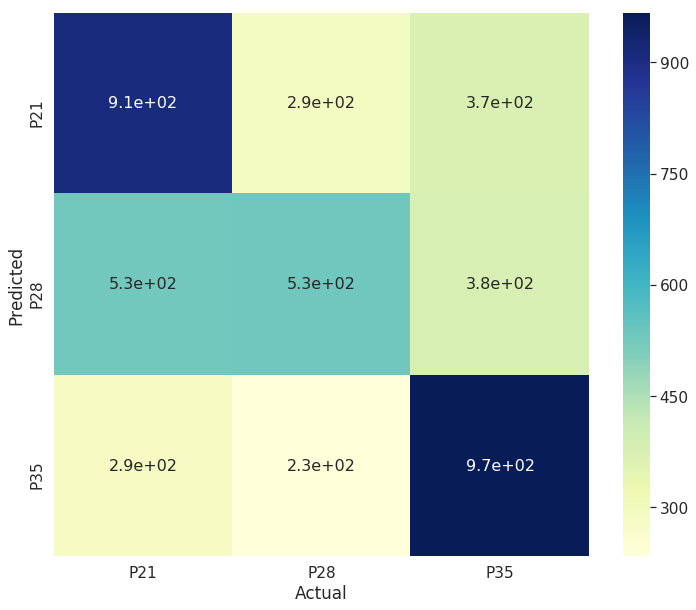

In [58]:
confusion_matrix(y_test, pred)
pl.figure(figsize=(12,10))
cm_array = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")
ax.set(xlabel='Actual', ylabel='Predicted')

pl.show()

* Training trajectories for each age
* Weighted score at the bottom
* 

In [59]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test[features])

In [395]:
top_feat = ['Mean Deff1', 'Mean fractal_dim', 'Mean D_fit', 'Mean MSD_ratio', 'Mean kurtosis', 'Mean Deff2']

In [65]:
%matplotlib inline

In [60]:
from matplotlib import colors as plt_colors

In [63]:
class_inds

array([2, 1, 0])

In [62]:
colors = ['#e5bf62', '#7995e9', '#a64ca6']
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])

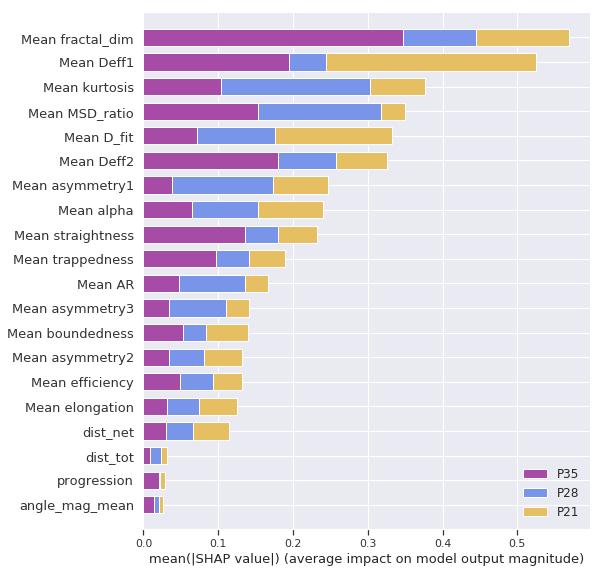

In [66]:
shap.summary_plot(shap_values, X_test[features], class_names=np.array(class_names), title='Total SHAP Values', color=cmap)

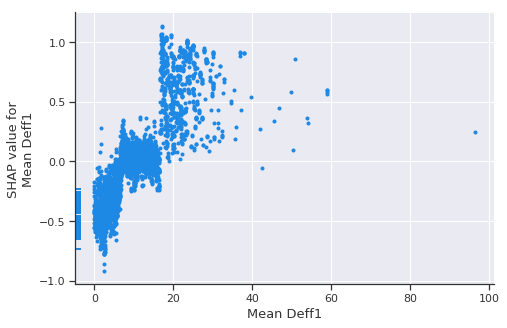

In [67]:
shap.dependence_plot("Mean Deff1", shap_values[0], X_test[features], interaction_index = None)

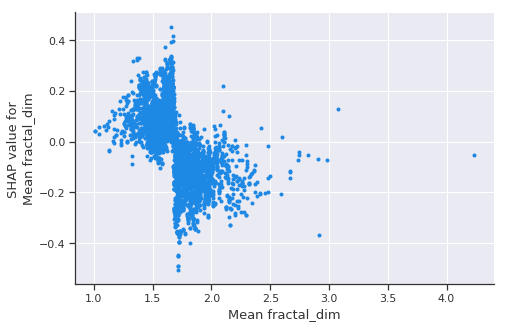

In [68]:
shap.dependence_plot("Mean fractal_dim", shap_values[0], X_test[features], interaction_index = None)

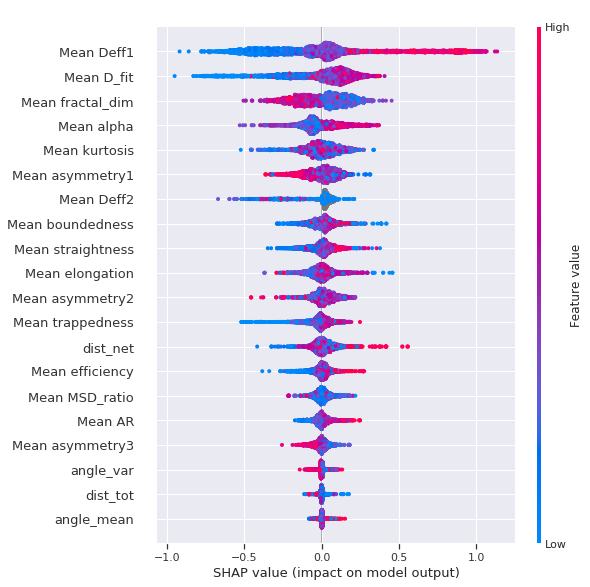

In [69]:
shap.summary_plot(shap_values[0], X_test[features], class_names = class_names, title = 'SHAP Value for P14')

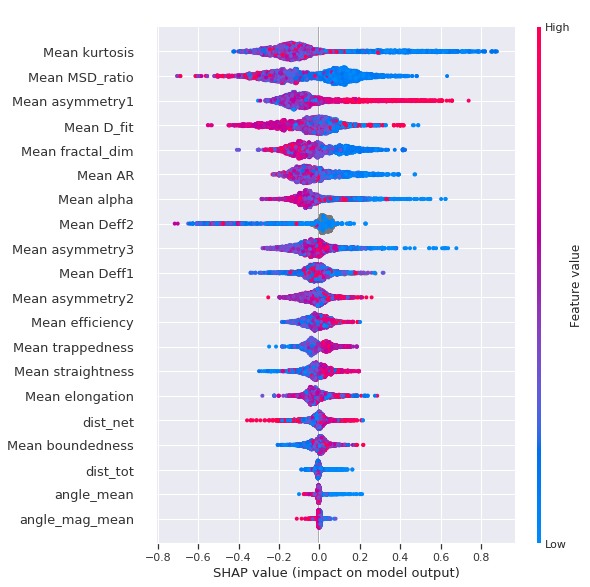

In [70]:
shap.summary_plot(shap_values[1], X_test[features], class_names = class_names, title = 'SHAP Value for P21')

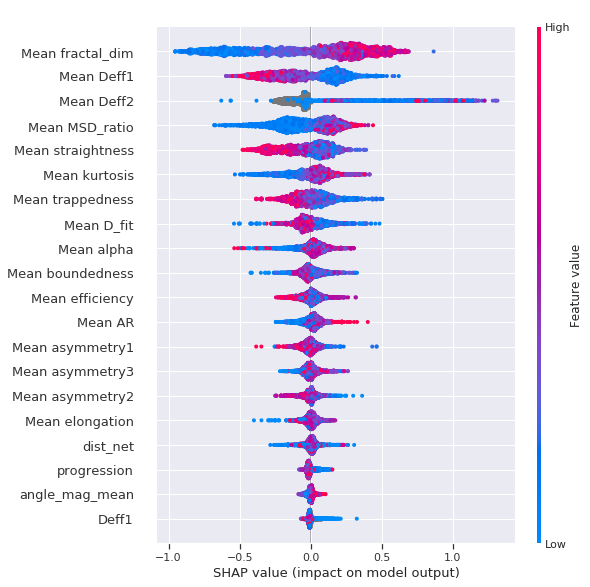

In [71]:
shap.summary_plot(shap_values[2], X_test[features], class_names = class_names, title='SHAP Value for P28')

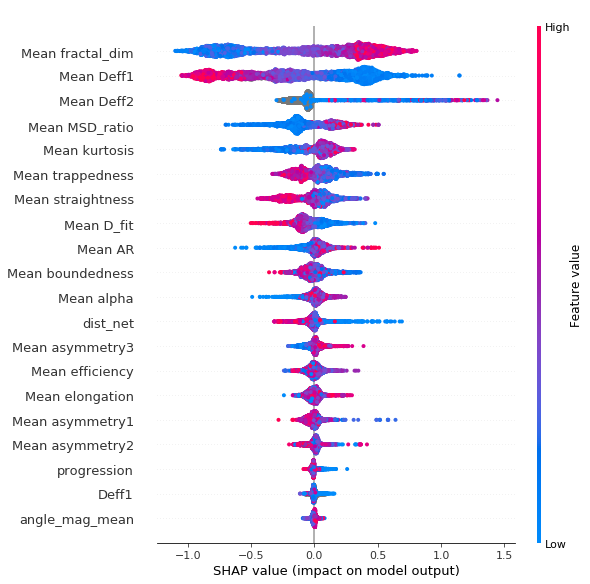

In [385]:
shap.summary_plot(shap_values[3], X_test[features], class_names = class_names, title = 'SHAP Value for P35')

MovieWriter imagemagick unavailable. Trying to use pillow instead.


KeyboardInterrupt: 

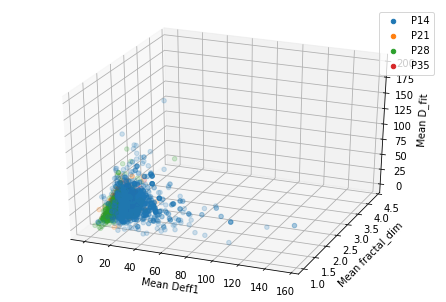

In [473]:
from modules import anim_plot
from importlib import reload
reload(anim_plot)

_ = anim_plot.rotate_3d(results, top_feat[0], top_feat[1], top_feat[2])
_ = anim_plot.rotate_3d(results, top_feat[0], top_feat[2], top_feat[3])
_ = anim_plot.rotate_3d(results, top_feat[1], top_feat[2], top_feat[3])

In [ ]:
from IPython.display import Image, display
X = Image('./rotation_MeanDeff1_MeanD_fit_MeanMSD_ratio.gif')
display(X)

In [ ]:
rot_animation = animation.FuncAnimation(fig, rotate, init_func=init, frames=np.arange(0,362,2),interval=None)

* Try analysis without P21 data
* Try combining
* [Done] Do a video of 3d plots
* SHAP summitive
* SHAP bounds
* Keep wrking on random forest


* While waiting for review
* Pot. change algorithm to rand forest


* On exp end, Mike will get adult dataset


* Make methods: how data was split, how training eval test, SHAP, algorithm, link to github
* Wrk on discusion (why, limitations, etc)
* Results

* Nxt chkpt: January 17th 

In [ ]:
ap.